# Fit some LBTI null depths
Assume for now that we have some null depths given at instantaneous hour angles. Transmitted disk flux is convolved with 1d PSF and apertures used to get nulls.

Possible improvements:
 - Include sky annuli for aperture photometry.
 - A some uniformly spaced points in HA within each block.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ni
from multiprocessing.pool import Pool
import emcee
import corner

%matplotlib notebook

In [2]:
# make some ~fake data that look suspiciously
# like beta Leo's
ha = np.array([-1,0,1])

# aperture sizes in arcsec
ap = [0.1, 0.2, 0.3, 0.4]

# measurements for each ha and aperture
null = [[4e-3, 4e-3, 4e-3],
        [6.5e-3, 6.5e-3, 6.5e-3],
        [8e-3, 8e-3, 8e-3],
        [9e-3, 9e-3, 9e-3]]

e_null = [[1e-3, 1e-3, 1e-3],
          [1e-3, 1e-3, 1e-3],
          [1e-3, 1e-3, 1e-3],
          [1e-3, 1e-3, 1e-3]]

In [3]:
# stellar properties
dist = 11
dec = 14.6
lstar = 13.7
fstar = 5.5

In [4]:
# get the observatory
ob = ni.Observatory()

# get the parallactic angles for the given hour angles
pl = np.deg2rad(ob.parallactic_angle(ha, dec, has_input='ha'))

In [5]:
def bnu_jy_sr(wav, t):
    '''Planck function'''
    k1 = 3.9728949e19     
    k2 = 14387.69         
    wav = float(wav)
    t = np.array(t,dtype=float)
    fact1 = k1/(wav**3)
    fact2 = k2/(t*wav)
    ret = np.array(fact1/(np.exp(fact2)-1.0))
    return ret

In [6]:
# set up a disk and compute things that don't change
# do this instead of using ni's Disk class since that
# uses radii of r_in to r_out, which would be a pain
# for the convolution
nr = 500
rmax = 10
dr = rmax/nr
r_au = np.linspace(dr/2, rmax-dr/2, num=nr)
r_as = r_au / dist
tbb = 278.3*(lstar**0.25)/np.sqrt(r_au)
bnu = bnu_jy_sr(ob.wav, tbb)
sigzodi = 7.11889e-8
r0 = np.sqrt(lstar)
aream = 2*np.pi*r_au*dr
alpha = 0.34

def fnu_disk(p):
    ok = (r_au > p[0]) & (r_au < p[1])
    area = aream.copy()
    area[np.invert(ok)] = 0
    bigsig = sigzodi*p[5]*(r_au/r0)**(-p[2])
    sig = area*bigsig
    return (2.95e-10)*bnu*(0.25*sig/np.pi)/dist**2

In [7]:
# get stellar PSF, and mirrored version for convolution, and normalise
psf = ob.psf(r_as)
psf /= np.sum(psf)
psf_mir = np.append(np.flipud(psf),psf)
psf_mir /= np.sum(psf_mir)
r_as_mir = np.append(-np.flipud(r_as),r_as)

In [8]:
# indices for apertures in radius array
i_ap = []
psf_frac = []
for a in ap:
    i_ap.append(np.where(r_as > a)[0][0])
    psf_frac.append(np.cumsum(psf)[i_ap[-1]])
    print(i_ap[-1], psf_frac[-1])

55 0.5578320791534455
110 0.8723291148255309
165 0.9772832352738714
220 0.9975784702581841


In [9]:
# initial parameters and limits
param_names = ['rin', 'rout', 'alpha', 'inc', 'pa', 'zodi']

p0 = np.array([0.05, 5, 0.34, np.deg2rad(45), np.deg2rad(90), 100])

p_lim = [[0.01, rmax],
         [0.01, rmax],
         [-2, 2],
         [0, np.pi/2],
         [0, np.pi],
         [0, np.inf]]

In [10]:
def chi2(p, return_fd=False, return_fd_t=False, return_conv=False, return_null=False):
    
    for p_,plim in zip(p,p_lim):
        if p_ < plim[0]:
            return np.inf
        if p_ > plim[1]:
            return np.inf
    if p[0] > p[1]:
        return np.inf
    
    # get the disk flux, setting to zero outside edges
    fd = fnu_disk(p)
    if return_fd:
        return fd

    # get the azimuthally averaged transmission function for
    # the hour angles and this disk orientation, shape nr x nha
    tx = ob.transmission(r_as, inc=[p[3]], omegalbti=p[4]-pl)
    
    # tile flux and transmit
    fd_t = np.tile(fd, (len(ha),1)).T * tx
    if return_fd_t:
        return fd_t

    # convolve mirrored flux, and get half of this
    fd_t_mir = np.vstack((np.flipud(fd_t),fd_t))
    fd_t_conv = np.zeros_like(fd_t)
    for i in range(len(ha)):
        fd_t_conv[:,i] = np.convolve(fd_t_mir[:,i], psf_mir, mode='same')[nr:]
    if return_conv:
        return fd_t_conv
        
    c2 = 0
    null_mod = []
    fd_t_conv_cum = np.cumsum(fd_t_conv, axis=0)
    # loop over apertures
    for j,tmp in enumerate(zip(i_ap, null, e_null)):
        i,n,e = tmp
        nd = fd_t_conv_cum[i] / (fstar*psf_frac[j])
        null_mod.append(nd)
        c2 += np.sum( ((n-nd)/e)**2 )
        
    if return_null:
        return null_mod
    
    return c2


def lnlike(p):
    return -0.5 * chi2(p)

In [11]:
%timeit lnlike(p0)
lnlike(p0)

3.63 ms ± 35.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


-5.5402953188215225

In [12]:
nwalkers = 250
npar = len(p0)
nstep = 1000

start_pos = [p0 + 0.01*p0*np.random.normal(size=npar) for i in range(nwalkers)]

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, npar, lnlike, pool=pool)
    pos,lnprob,rstate = sampler.run_mcmc(start_pos, nstep, progress=True)

100%|██████████| 1000/1000 [03:32<00:00,  4.70it/s]


<IPython.core.display.Javascript object>


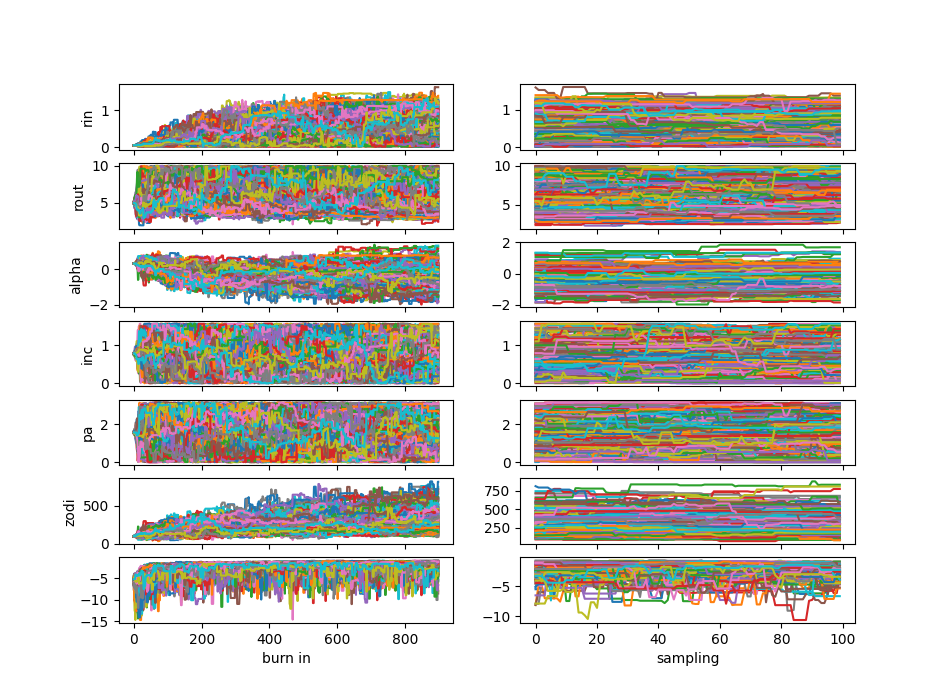

Text(0.5, 0, 'sampling')

In [13]:
burn = 900

fig,ax = plt.subplots(sampler.chain.shape[2]+1,2,figsize=(9.5,7),sharex='col',sharey=False)

for j in range(sampler.chain.shape[0]):
    ax[-1,0].plot(sampler.lnprobability[j,:burn])
    for i in range(sampler.chain.shape[2]):
        ax[i,0].plot(sampler.chain[j,:burn,i])
        if param_names is not None:
            ax[i,0].set_ylabel(param_names[i])

for j in range(sampler.chain.shape[0]):
    ax[-1,1].plot(sampler.lnprobability[j,burn:])
    for i in range(sampler.chain.shape[2]):
        ax[i,1].plot(sampler.chain[j,burn:,i])

ax[-1,0].set_xlabel('burn in')
ax[-1,1].set_xlabel('sampling')

<IPython.core.display.Javascript object>


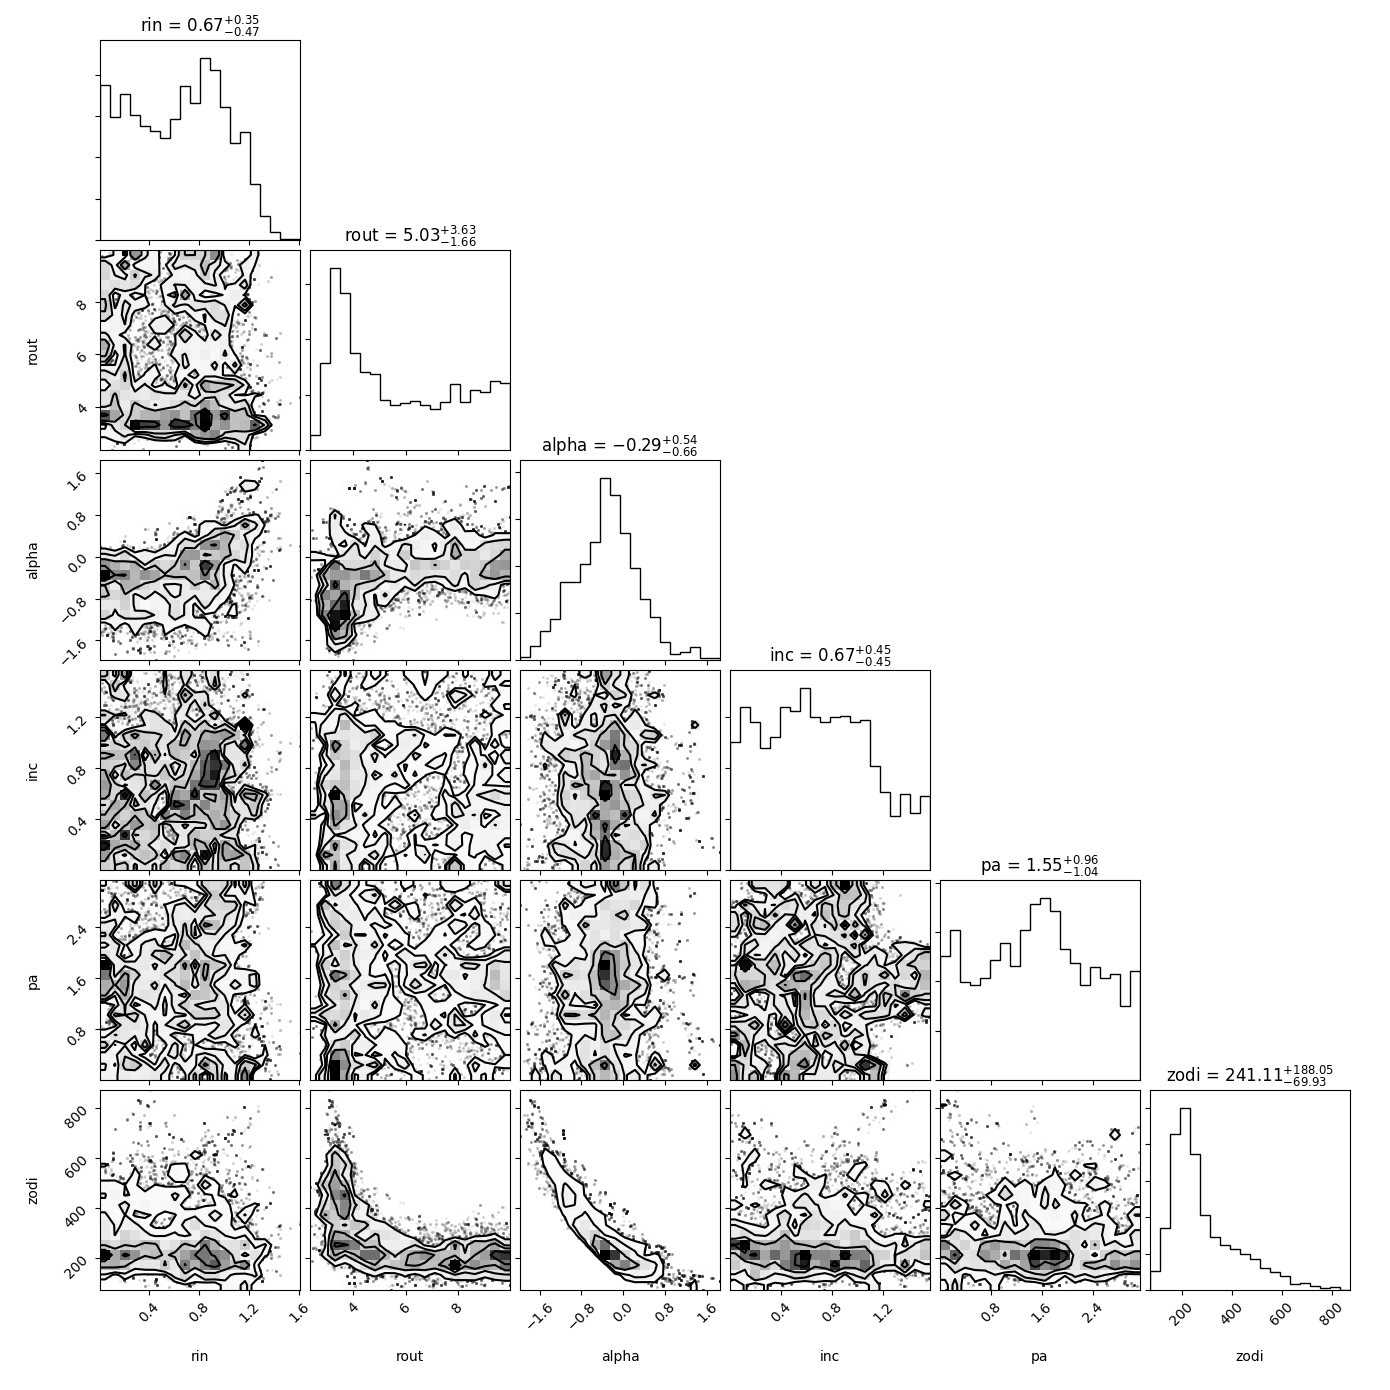

In [14]:
_ = corner.corner(sampler.chain[:,burn:,:].reshape(-1,npar), show_titles=True, labels=param_names)

<IPython.core.display.Javascript object>


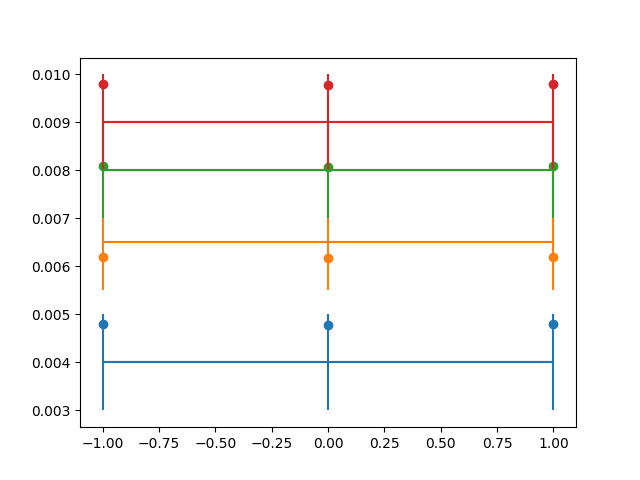

In [15]:
fig, ax = plt.subplots()
nd = chi2(np.median(sampler.chain[:,burn:,:].reshape(-1,npar), axis=0), return_null=True)
# nd = chi2(p0, return_null=True)
for i in range(len(ap)):
    ax.plot(ha, null[i], color='C{}'.format(i))
    ax.errorbar(ha, null[i], e_null[i], color='C{}'.format(i))
    ax.scatter(ha, nd[i], c='C{}'.format(i))

<IPython.core.display.Javascript object>


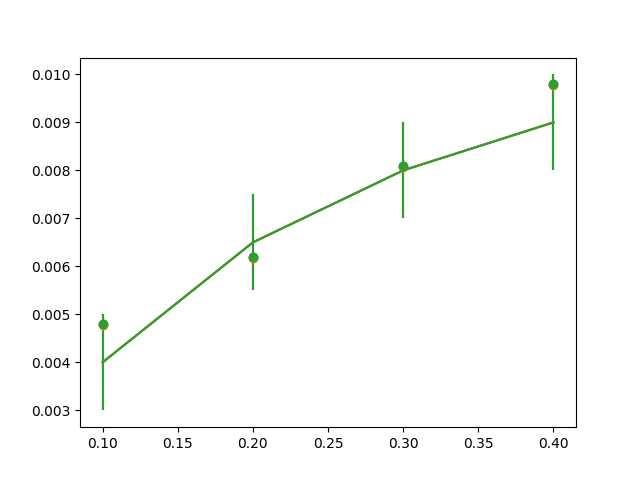

In [16]:
fig, ax = plt.subplots()
for i in range(len(ha)):
        ax.errorbar(ap, np.array(null)[:,i], np.array(e_null)[:,i], color='C{}'.format(i))
        ax.plot(ap, np.array(nd)[:,i], 'o', color='C{}'.format(i))